# Analyzing pressure data (ceiling, pitot, and Elliott) from Scanivalve MPS sensor

## Experiment parameters

* Date: 2019-12-03
* Tank: SUSTAIN
* Start time: 17:30 UTC
* Wind only, no paddle
* Fan from 0 to 60 Hz in 5 Hz intervals, each run 600 s (10 minutes)
* Fresh water
* Mean water depth: 0.8 m

**Note: Experiment stopped, last run being 50 Hz.**

In [1]:
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.irgason import read_irgason_from_toa5, eddy_covariance_flux
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191203'
data = pd.read_csv(DATAPATH + '/scanivalve_mps_20191203.csv')
time = data['FTime']

fan = range(0, 55, 5)
x = fetch['static_pressure']
run_seconds = 600

start_time = datetime(2019, 12, 3, 17, 30)

In [3]:
data

,Frame,Valve,XTime,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,...,55Press,56Press,57Press,58Press,59Press,60Press,61Press,62Press,63Press,64Press
0,1,Px,0.0,41.00,40.81,41.13,40.69,41.31,40.81,41.25,...,-0.740344,-0.508357,-1.269866,-1.293701,-1.343016,-0.996988,0.127860,-0.508563,-0.291370,-0.450001
1,2,Px,0.0,41.00,40.81,41.13,40.69,41.31,40.81,41.25,...,-0.778152,-0.473837,-1.458085,-1.487674,-1.753976,-1.415345,0.071327,-0.827262,-0.345617,-0.455343
2,3,Px,0.0,40.94,40.81,41.13,40.69,41.31,40.81,41.25,...,-0.375206,-0.606987,-1.099728,-1.282194,-1.539455,-1.283838,0.410549,-0.864659,-0.505480,-0.908632
3,4,Px,0.0,40.94,40.81,41.13,40.75,41.31,40.81,41.25,...,-0.238973,-0.517398,-0.946851,-1.296989,-1.407948,-0.895070,0.402458,-0.886029,-0.613563,-0.804659
4,5,Px,0.0,40.94,40.81,41.13,40.75,41.31,40.81,41.25,...,-0.120206,-0.699864,-1.472880,-1.167126,-1.480277,-0.575344,-0.071353,-0.612946,-0.191507,-0.848632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83995,83996,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,-0.131918,-0.955481,-1.086577,0.617261,-0.416713,-1.432606,0.901491,0.003493,-0.136028,0.002877
83996,83997,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,0.027945,-1.301920,-1.150687,0.778358,-0.341918,-0.776714,0.998709,0.347261,0.021370,-0.251507
83997,83998,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,0.152877,-1.200413,-1.223838,0.812878,-0.385480,-0.655070,0.707030,0.298973,-0.355891,-0.092877
83998,83999,Px,0.0,42.94,42.81,43.13,42.75,43.31,42.81,43.25,...,0.394316,-1.104249,-1.288770,0.637809,-0.522741,-1.011783,0.758349,-0.066370,-0.542878,0.134384


## Along-tank static pressure (ceiling)

### Raw data

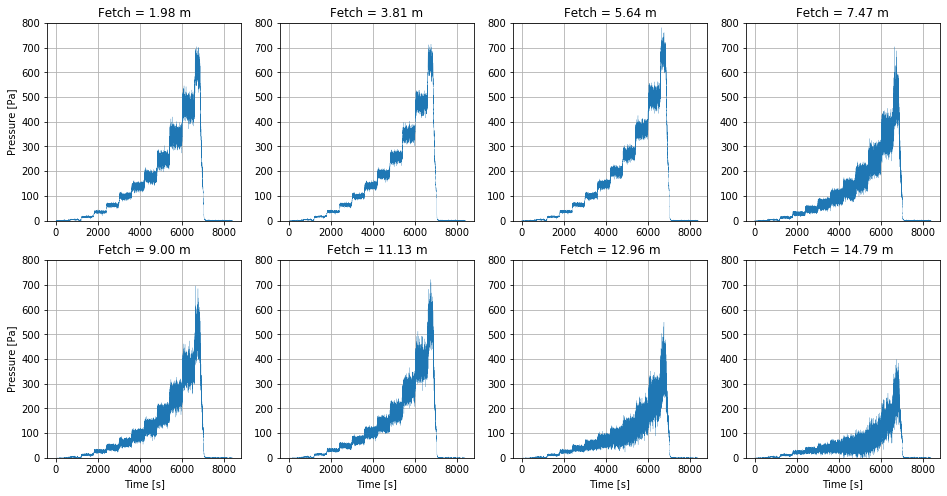

In [4]:
fig = plt.figure(figsize=(16, 8))
for j in range(2):
    for i in range(4):
        ax = plt.subplot2grid((2, 4), (j, i))
        pressure_index = j * 4 + i + 1
        ax.plot(time, data['%2.2i' % pressure_index + 'Press'], lw=0.2)
        plt.title('Fetch = %.2f m' % x[pressure_index - 1])
        plt.grid(True)
        plt.ylim(0, 800)
        if i == 0: plt.ylabel('Pressure [Pa]')
        if j == 1: plt.xlabel('Time [s]')

### Time-average for each fan speed

In [5]:
# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [n * run_seconds + 60 for n in range(len(fan))]
t1 = [(n + 1) * run_seconds for n in range(len(fan))]

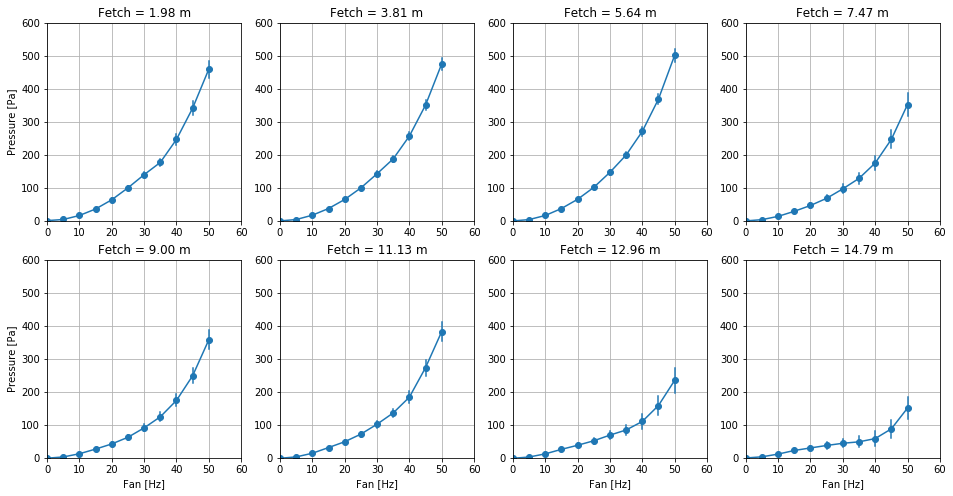

In [6]:
fig = plt.figure(figsize=(16, 8))
for j in range(2):
    for i in range(4):
        ax = plt.subplot2grid((2, 4), (j, i))
        pressure_index = j * 4 + i + 1
        pmean, pstd = [], []
        for n in range(len(fan)):
            mask = (time >= t0[n]) & (time <= t1[n])
            pres = data['%2.2iPress' % pressure_index][mask]
            pmean.append(np.mean(pres))
            pstd.append(np.std(pres))
        ax.plot(fan, pmean, marker='o')
        for n in range(len(fan)):
            ax.plot([fan[n], fan[n]], [pmean[n] - pstd[n], pmean[n] + pstd[n]], color='tab:blue')
        plt.title('Fetch = %.2f m' % x[pressure_index - 1])
        plt.grid(True)
        plt.xlim(0, 60)
        plt.ylim(0, 600)
        if i == 0: plt.ylabel('Pressure [Pa]')
        if j == 1: plt.xlabel('Fan [Hz]')

In [7]:
pmean = np.zeros((len(fan), 8))
pstd = np.zeros((len(fan), 8))
for i in range(8):
    for n in range(len(fan)):
            mask = (time >= t0[n]) & (time <= t1[n])
            pres = data['%2.2iPress' % (i + 1)][mask]
            pmean[n,i] = np.mean(pres)
            pstd[n,i] = np.std(pres)

Text(0.5, 1.0, 'Time-averaged static pressure [Pa] at SUSTAIN ceiling as function of fan and fetch')

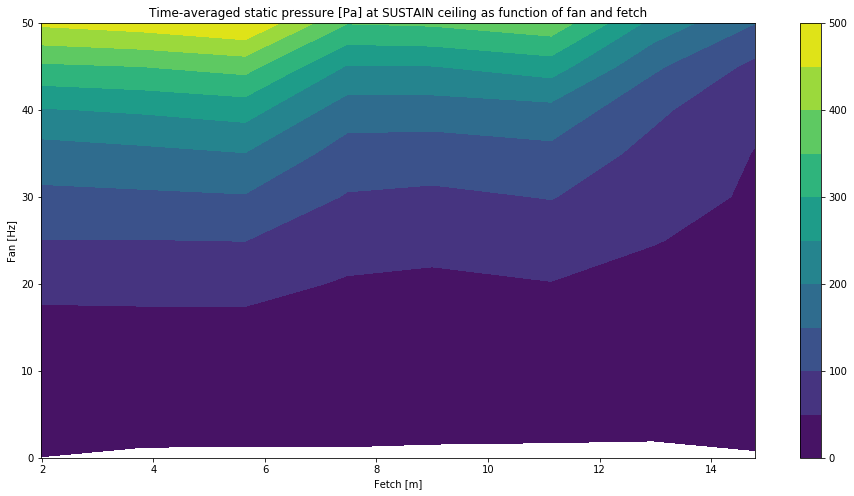

In [8]:
fig = plt.figure(figsize=(16, 8))
plt.contourf(x, fan, pmean, np.arange(0, 550, 50))
plt.colorbar()
plt.xlabel('Fetch [m]')
plt.ylabel('Fan [Hz]')
plt.title('Time-averaged static pressure [Pa] at SUSTAIN ceiling as function of fan and fetch')

Text(0.5, 1.0, 'Standard deviation of static pressure [Pa] at SUSTAIN ceiling as function of fan and fetch')

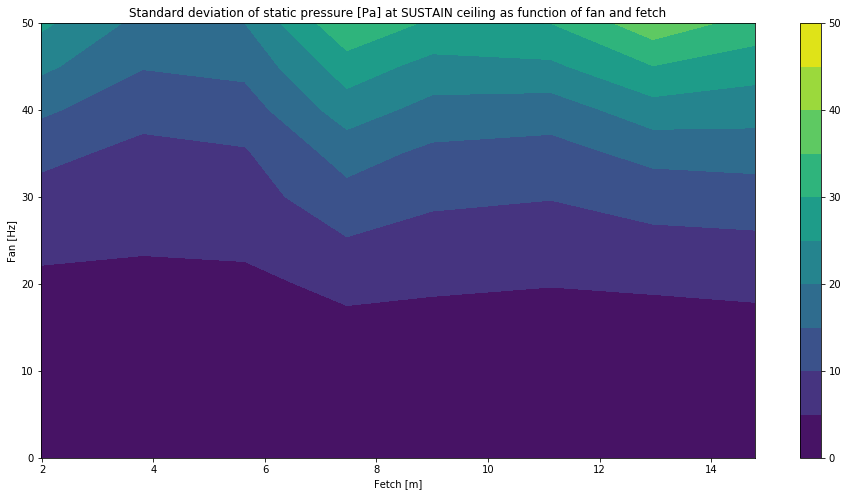

In [9]:
fig = plt.figure(figsize=(16, 8))
plt.contourf(x, fan, pstd, np.arange(0, 55, 5))
plt.colorbar()
plt.xlabel('Fetch [m]')
plt.ylabel('Fan [Hz]')
plt.title('Standard deviation of static pressure [Pa] at SUSTAIN ceiling as function of fan and fetch')

Text(0.5, 1.0, 'Time-averaged Static pressure vs. fetch for each fan speed')

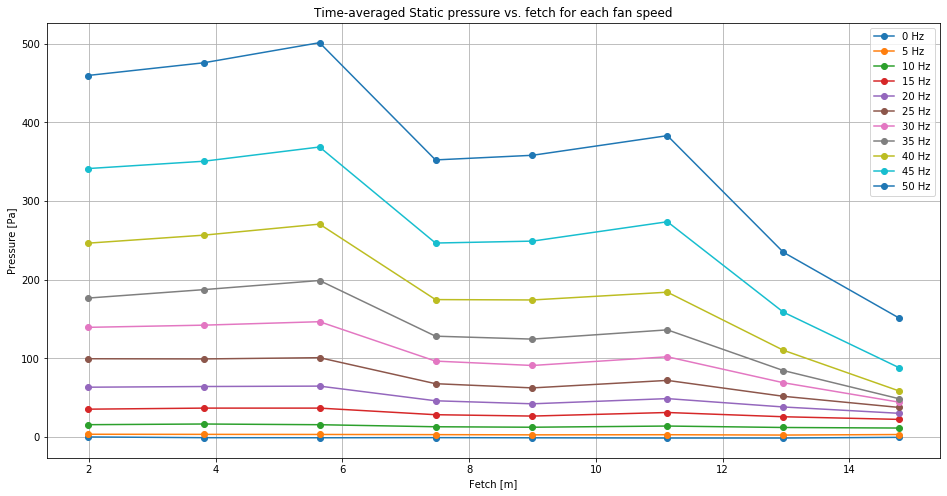

In [10]:
fig = plt.figure(figsize=(16, 8))
for n in range(len(fan)):
    plt.plot(x, pmean[n,:], marker='o', label=str(fan[n]) + ' Hz')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Fetch [m]')
plt.ylabel('Pressure [Pa]')
plt.title('Time-averaged Static pressure vs. fetch for each fan speed')

## Pressure gradient

We'll find the along-tank pressure gradient by fitting a line to the pressure at each fan speed.

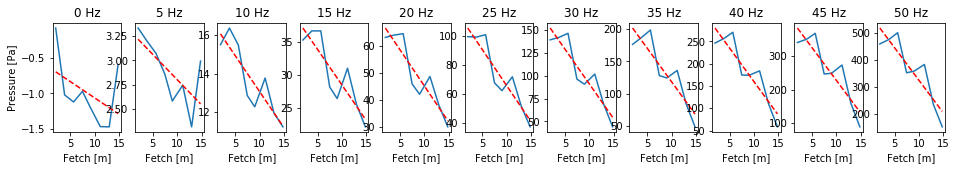

In [11]:
fig = plt.figure(figsize=(16, 2))
dpdx = np.zeros(len(fan))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    plt.plot(x, pmean[n,:])
    p = np.polyfit(x, pmean[n,:], 1)
    fit = np.polyval(p, x)
    plt.plot(x, fit, 'r--')
    plt.xlabel('Fetch [m]')
    if n == 0: plt.ylabel('Pressure [Pa]')
    plt.title(str(fan[n]) + ' Hz')
    dpdx[n] = (fit[-1] - fit[0]) / (x[-1] - x[0])

## Mean along-tank pressure gradient vs. fan speed

### Load ASIST data

Notes:
* ASIST is 1 m tall, 1 m wide, with 0.42 m of water in it
* SUSTAIN is 2 m tall, 6 m wide, with 0.80 m of water in it

In [12]:
asist_cross_area = (1 - 0.42) * 1
sustain_cross_area = (2 - 0.8) * 6
print('ASIST cross-area: %.2f m^2' % asist_cross_area)
print('SUSTAIN cross-area: %.2f m^2' % sustain_cross_area)

ASIST cross-area: 0.58 m^2
SUSTAIN cross-area: 7.20 m^2


In [13]:
ASIST_DATA_PATH = '/home/milan/Work/sustain/data/asist-nsf-2018'
with Dataset(ASIST_DATA_PATH + '/nsf-drag-2018_asist-windonly-fresh.nc') as nc:
    asist_fan = nc.variables['fan'][:]
    asist_U = nc.variables['U_irgason'][:]
    asist_dpdx = nc.variables['air_pressure_gradient'][:]

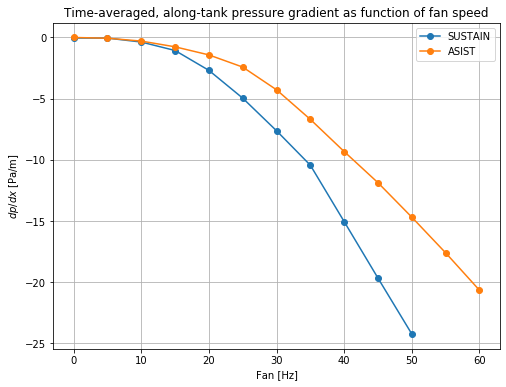

In [14]:
fig = plt.figure(figsize=(8, 6))
plt.plot(fan, dpdx, marker='o', label='SUSTAIN')
plt.plot(asist_fan, asist_dpdx, marker='o', label='ASIST')
plt.legend(loc='upper right')
plt.xlabel('Fan [Hz]')
plt.ylabel(r'$dp/dx$ [Pa/m]')
plt.title('Time-averaged, along-tank pressure gradient as function of fan speed')
plt.grid()

## Pressure gradient against wind speed

### Load IRGASON data

In [15]:
def get_stress_from_irgason(irgason_files, start_time, fan):
    """Returns mean wind speed and stress directly from IRGASON TOA5 files."""
    time, irg1, irg2 = read_irgason_from_toa5(irgason_files)
    
    t0 = [start_time + timedelta(seconds=n * run_seconds + 60)
        for n in range(len(fan))]
    t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
        for n in range(len(fan))]
    
    U1, Ustd1, Wstd1, uw1 = eddy_covariance_flux(irg1, time, t0, t1, fan)
    U2, Ustd2, Wstd2, uw2 = eddy_covariance_flux(irg2, time, t0, t1, fan)
    
    return U1, uw1, U2, uw2

In [16]:
# Experiment 2019-12-03
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191203'
irgason_files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_Wind.FAST*.dat')
U1, uw1, U2, uw2 = get_stress_from_irgason(irgason_files, start_time, fan)

Reading  TOA5_SUSTAIN_Wind.FAST_757_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_759_2019_12_03_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_758_2019_12_03_1800.dat
Processing IRGASON time series..


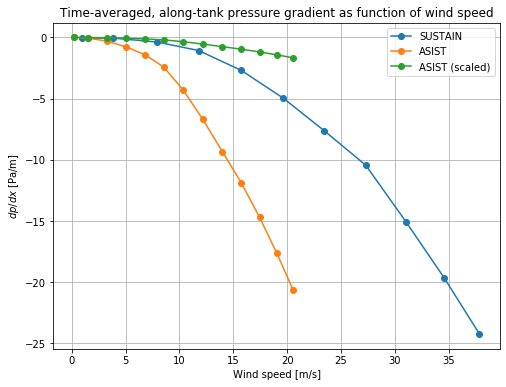

In [17]:
fig = plt.figure(figsize=(8, 6))
plt.plot(U1, dpdx, marker='o', label='SUSTAIN')
plt.plot(asist_U, asist_dpdx, marker='o', label='ASIST')
plt.plot(asist_U, asist_dpdx * asist_cross_area / sustain_cross_area, marker='o', label='ASIST (scaled)')
plt.legend(loc='upper right')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r'$dp/dx$ [Pa/m]')
plt.title('Time-averaged, along-tank pressure gradient as function of wind speed')
plt.grid()